# Notebook using HayStack's NLP Framework for song lyrics semantic search.

Install HayStack and download data ([source](https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres))

In [1]:
!pip install git+https://github.com/deepset-ai/haystack.git
!gdown --id 1sZnUoO-zZMV4Fp0kO5TDZ1Bf8pERzjcd
!unzip archive.zip

  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-req-build-qor3fx_h
  Running command git clone -q https://github.com/deepset-ai/haystack.git /tmp/pip-req-build-qor3fx_h
     |████████████████████████████████| 43 kB 976 kB/s 
     |████████████████████████████████| 14.1 MB 30 kB/s 
     |████████████████████████████████| 2.5 MB 34.1 MB/s 
     |████████████████████████████████| 51 kB 563 kB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 321 kB 54.4 MB/s 
     |████████████████████████████████| 351 kB 70.2 MB/s 
     |████████████████████████████████| 85 kB 2.4 MB/s 
     |████████████████████████████████| 981 kB 58.8 MB/s 
     |████████████████████████████████| 3.0 MB 46.4 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 5.6 MB 43.7 MB/s 
     |████████████████████████████████| 100 kB 10.3 MB/s 
     |█████████

Downloading...
From: https://drive.google.com/uc?id=1sZnUoO-zZMV4Fp0kO5TDZ1Bf8pERzjcd
To: /content/archive.zip
100% 79.5M/79.5M [00:00<00:00, 141MB/s]
Archive:  archive.zip
  inflating: artists-data.csv        
  inflating: lyrics-data.csv         


# Build a Document Store and Retriever

Before indexing with the [DocumentStore](https://haystack.deepset.ai/reference/document-store) the data is pre-processed by:

*   Keeping english lyrics only
*   Remove duplicate lyrics
*   Remove short lyrics that describe only instruments being played with no singing



In [ ]:
import pandas as pd

directory = '/content/lyrics-data.csv'

def custom_preprocess(data):
    instrumental_lst = ['Instrumental', 'instrumental', '[Instrumental]', '(Instrumental)', '(instrumental)', '[instrumental]', '[This song is an instrumental.]']

    data = data[~data.Lyric.isin(instrumental_lst)]
    data = data[data.Lyric.notna() & data.Idiom.notna()]
    data = data.drop_duplicates('Lyric', keep='last')
    return data


def convert_file_to_dict(directory, english_only=True):

  lyrics = pd.read_csv(directory)
  lyrics = custom_preprocess(lyrics)
  lyrics = lyrics[lyrics.Idiom == 'ENGLISH']

  songs_records = []
  for song in lyrics.itertuples():
      songs_records.append(
          {
              'content': song.Lyric,
              'meta': {'name': song.SName, 'Idiom': song.Idiom, 'link': song.ALink}
          }
      )

  return songs_records

docs = convert_file_to_dict(directory)

Further pre-process using HayStack's built-in pre-processing tool

In [ ]:
from haystack.nodes import PreProcessor

processor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=False,
    split_by="word",
    split_length=200,
    split_respect_sentence_boundary=True,
    split_overlap=0
)

norm_docs = [processor.clean(doc, clean_whitespace=True, clean_empty_lines=True, clean_header_footer=True) for doc in docs]
#norm_docs = [processor.split(doc, split_by='word', split_length=500, split_overlap=0, split_respect_sentence_boundary=True) for doc in norm_docs for doc in docs]

/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


Build DocumentStore with FAISS for fast dense retrieval.

In [ ]:
#@title Document Store Type
from haystack.document_stores import FAISSDocumentStore
similarity = 'dot_product' #@param ["dot_product", "cosine"]
vector_dimension = 768  #@param [384, 768]


document_store = FAISSDocumentStore(faiss_index_factory_str="Flat", 
                                    sql_url="sqlite:///my_doc_store.db", 
                                    similarity=similarity,
                                    vector_dim=vector_dimension)

document_store.write_documents(norm_docs, duplicate_documents='skip')

## Build the Retriever and update DocumentStore embeddings (use one of the two following cells):

The Retriever is a lightweight filter that can quickly go through the full document store and pass on a set of candidate documents that are relevant to the query. When used in combination with a Reader, it is a tool for sifting out irrelevant documents.

### DRP

In [ ]:
from haystack.nodes import DensePassageRetriever, EmbeddingRetriever
#@title DPR embedding Encoder

query_embedding_model = 'facebook/dpr-question_encoder-single-nq-base' #@param ["facebook/dpr-question_encoder-single-nq-base"]
passage_embedding_model = 'facebook/dpr-ctx_encoder-single-nq-base' #@param ["facebook/dpr-ctx_encoder-single-nq-base"]
max_seq_len_query = 64 #@param {type:"number"}
max_seq_len_passage = 256 #@param {type:"number"}
batch_size = 16 #@param {type:"number"}
encode_song_title = True #@param {type:"boolean"}
use_gpu = True #@param {type:"boolean"}

retriever = DensePassageRetriever(document_store=document_store,
                                  query_embedding_model=query_embedding_model,
                                  passage_embedding_model=passage_embedding_model,
                                  max_seq_len_query=max_seq_len_query,
                                  max_seq_len_passage=max_seq_len_passage,
                                  batch_size=batch_size,
                                  use_gpu=use_gpu,
                                  embed_title=True,
                                  use_fast_tokenizers=True)

document_store.update_embeddings(retriever)
document_store.save("my_faiss")

Updating Embedding:   0%|          | 0/100 [00:00<?, ? docs/s]

Create embeddings:   0%|          | 0/112 [00:00<?, ? Docs/s]

Documents Processed: 10000 docs [00:03, 2961.06 docs/s]


### Sentence-Transformers (Recommended)

In [ ]:
from haystack.nodes import EmbeddingRetriever

#@markdown ⚠️ Check if the model was trained using dot-product or cosine similarity (check model cart) and adjust DocumentStore accordingly. ⚠️
model_name = 'sentence-transformers/msmarco-distilbert-base-tas-b' #@param ["sentence-transformers/msmarco-distilbert-base-tas-b", "multi-qa-MiniLM-L6-cos-v1"]
pooling_strategy = 'cls_token' #@param ["cls_token", "reduce_mean", "reduce_max", "per_token"]

model_format = 'sentence_transformers'
use_gpu = True #@param {type:"boolean"}

retriever = EmbeddingRetriever(document_store=document_store,
                               embedding_model=model_name,
                               use_gpu=use_gpu,
                               model_format=model_format,
                               pooling_strategy=pooling_strategy)

document_store.update_embeddings(retriever)
document_store.save("my_faiss")

# Load an existing Document Store and Retriever (Start here for a quick test)

## Download and unpack DocumentStore

In [5]:
import os

!gdown --id 12uIl0W76u6KStWHAw0gzvv1Wm8nj7bqr

folder_name = 'document_store'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

!unzip ./document_store.zip -d ./document_store/
!rm ./document_store.zip

Downloading...
From: https://drive.google.com/uc?id=12uIl0W76u6KStWHAw0gzvv1Wm8nj7bqr
To: /content/document_store.zip
100% 334M/334M [00:02<00:00, 119MB/s]
Archive:  ./document_store.zip
Created by ZIP Extractor v4.25 on 2021-11-05
replace ./document_store/my_faiss? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./document_store/my_faiss  
replace ./document_store/my_faiss.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./document_store/my_faiss.json  
replace ./document_store/my_doc_store.db? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./document_store/my_doc_store.db  
y


## Load the DocumentStore and build the Retriever

The embeddings saved in the DocumentStore were obtained from [sentence-transformers/msmarco-distilbert-base-tas-b](https://https://huggingface.co/sentence-transformers/msmarco-distilbert-base-tas-b). Therefore, we build the Retriever with the same model.

The Retriever encodes the query and lookups in the DocumentStore and returns the top-n most similar song lyrics. Since the query and the documents are different in length, the model mentioned above is ideal for asymmetric semantic search. More info [here](https://www.sbert.net/examples/applications/semantic-search/README.html)

In [6]:
from haystack.document_stores import FAISSDocumentStore
from haystack.nodes import EmbeddingRetriever

index_path = './document_store/my_faiss'
config_path = './document_store/my_faiss.json'

document_store = FAISSDocumentStore.load(index_path=index_path, 
                                          config_path=config_path)

model_name = 'sentence-transformers/msmarco-distilbert-base-tas-b'
retriever = EmbeddingRetriever(document_store=document_store,
                               embedding_model=model_name,
                               use_gpu=True,
                               model_format='sentence_transformers',
                               pooling_strategy='cls_token')

You are using a Sentence Transformer with the dot_product function. We recommend using cosine instead. This can be set when initializing the DocumentStore


# Semantic Search

## Retriever Only (Bi-Encoder)

Run the cell below for a quick test!

In [10]:
import ipywidgets as widgets
import pandas as pd
from functools import partial
from IPython.display import clear_output, HTML
pd.set_option('max_colwidth', 2000)

outputs = widgets.Output()
layout_text = widgets.Layout(width='1000px', height='40')
layout_topk = widgets.Layout(width='150px', height='40')

text1 = widgets.Text(description='Query', layout=layout_text)

button = widgets.Button(description="🔎")
topk_box = widgets.IntText(
    value=20,
    description='Top k',
    disabled=False,
    layout=layout_topk
)

def get_result(text_field, topk ,button):

    with outputs:
        clear_output()
        results = retriever.retrieve(text_field.value, top_k=topk.value)
        df_results = pd.DataFrame(data=results)
        partial_results = df_results[["meta", "content", "score"]]
        display(partial_results)

button.on_click(partial(get_result, text1, topk_box))
display(text1, topk_box, button)
display(outputs)

# Example queries: Q (Query) R (model predition rank)
# ('This Road) Q: All heavy laden acquainted with sorrow R: 2 
# ('Mother Lover Q): its mothers day  he forgot a gift R: 8

Text(value='', description='Query', layout=Layout(height='40', width='1000px'))

IntText(value=20, description='Top k', layout=Layout(height='40', width='150px'))

Button(description='🔎', style=ButtonStyle())

Output()

## Retriever + Re-rank (Bi-Encoder + Cross-Encoder) 

While the Retriever is good for document retrieval, we can enhance the results with a ranker. Without a Ranker and its re-ranking step, the querying process is faster but the query results might be of lower quality.

We setup an efficient Bi-Encoder to retrieve e.g. the top-20 most similar song lyrics for a query. Then, we can a Cross-Encoder to re-rank these 20 hits by computing the score for every combination.

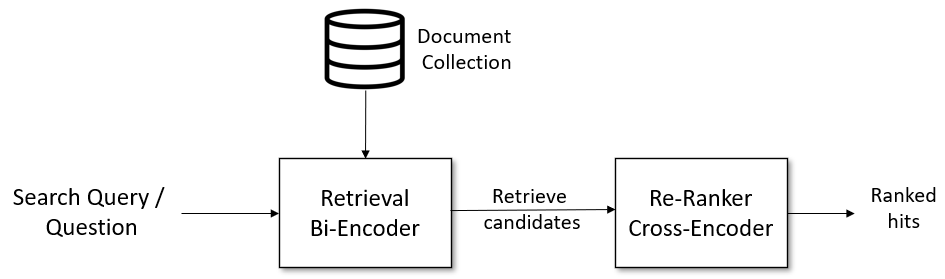

### Build the Pipeline



In [ ]:
from haystack import Pipeline
from haystack.nodes import SentenceTransformersRanker

cross_encoder = "cross-encoder/ms-marco-MiniLM-L-12-v2"
ranker = SentenceTransformersRanker(model_name_or_path=cross_encoder)

pipeline = Pipeline()
pipeline.add_node(component=retriever, name="ESRetriever", inputs=["Query"])
pipeline.add_node(component=ranker, name="Ranker", inputs=["ESRetriever"])

In [8]:
import ipywidgets as widgets
from functools import partial
from IPython.display import clear_output, HTML
pd.set_option('max_colwidth', 2000)

outputs = widgets.Output()
layout_text = widgets.Layout(width='1000px', height='40')
layout_topk = widgets.Layout(width='150px', height='40')

text1 = widgets.Text(description='Query: ', layout=layout_text)

button = widgets.Button(description="🔎")
topk_box_retriever = widgets.IntText(
    value=20,
    description='Retriever Top k',
    disabled=False,
    layout=layout_topk
)

topk_box_ranker = widgets.IntText(
    value=10,
    description='Ranker Top k',
    disabled=False,
    layout=layout_topk
)

def get_result(text_field, topk_retriever, topk_ranker, button):

    with outputs:
        clear_output()
        print("Loading...")     
        results = pipeline.run(query=text_field.value,
                           params={"ESRetriever": {"top_k": topk_retriever.value}, 
                                   "Ranker": {"top_k": topk_ranker.value}})['documents']
        
        df_results = pd.DataFrame(data=results)
        partial_results = df_results[["meta", "content", "score"]]
        display(partial_results)

button.on_click(partial(get_result, text1, topk_box_retriever, topk_box_ranker))
display(text1, topk_box_retriever, topk_box_ranker, button)
display(outputs)

Text(value='', description='Query: ', layout=Layout(height='40', width='1000px'))

IntText(value=20, description='Retriever Top k', layout=Layout(height='40', width='150px'))

IntText(value=10, description='Ranker Top k', layout=Layout(height='40', width='150px'))

Button(description='🔎', style=ButtonStyle())

Output()